In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10, 8)

**Ensemble learning**: aggregating the predictions of an ensemble of predictors to get a better performance than the best individual predictor.

Turns **weak learners** (those that perform only slightly better than random) into a combined **strong learner** (achieves high accuracy).

**Ensemble method**: the algorithm used bu ensemble learning

Various techniques:

- **Bagging/pasting**: same predictors, but train each on subset of training data (bagging = with replacement, pasting = without)

- **Random Patches/Subspaces**: same predictors, but train each on a subset of input features and/or data (patches = subset of both, subspaces = use all training data)

- **Random Forest**: ensemble of DTs trained via bagging, on random subset of features

- **Boosting**: add additional predictors that are trained on incorrectly predicted instances from previous predictor

- **Stacking**: add meta-learner to better combine results from multiple predictors

# Voting Classifiers

Train up a few classifiers: Logistic regression, SVM, Random Forest, K-NN. How to combine the results of each?

**Hard-voting classifier**: predict the class that gets the most votes

**Soft-voting classifier**: if you can get probabilities for each class, then instead can combine probabilities, find classes with highest averaged probability. Better than hard voting as more weight to highly confident votes. (For SVCs, need to enforce CV to estimate probabilities)

Let's make our own voting classifier:

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [5]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf),
        ('rf', rnd_clf),
        ('svc', svm_clf)
    ],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

Let's evaluate on the test set:

In [4]:
from sklearn.metrics import accuracy_score

In [8]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


So we can see that even though each classifier only had 86-90% accuracy, by combining them we get a 91% accuracy.

# Bagging & Pasting

Instead of using different classifiers, we can use the **same training algorithm** for every predictor, but train them on **different subsets** of the training data. Each training instance is sampled several times across multiple predictors.

**Bagging** (Bootstrap aggregating): subset samples are created **with replacement**. An instance may be sampled **several times by the same predictor**

**Pasting**: sampling done **without replacement**. Instances not sampled several times by same predictor.

Once all predictors trained, ensemble can make prediction by using mode (for classification), or average (for regression).

Each predictor has higher bias than on full training set, but combined result has similar bias & reduced variance.

Predictors can also be trained & evaluated in parallel - **scale well**.

In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, # number of base estimators in the ensemble
    max_samples=100, # number of samples to draw from X to train each base estimator
    bootstrap=True,  # True for bagging, False for pasting
    n_jobs=-1, # use all cores
    verbose=1
)
bag_clf.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.7s finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, verbose=1)

In [12]:
y_pred = bag_clf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


In [13]:
accuracy_score(y_pred, y_test)

0.912

Note that since DecisionTreeClassifier supports returning a probability (`predict_proba()`), the `BaggingClassifier` automatically performs soft voting.

How does this compare to a single DT?

In [14]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
y_pred_basic = dt_clf.predict(X_test)

In [15]:
accuracy_score(y_pred_basic, y_test)

0.872

So one DT by itself has an accuracy of 87%, whilst our bagging version of 500 DTs has an accuracy of 91%!

In [74]:
def draw_decision_regions(clf, x1_min, x1_max, x2_min, x2_max, ax=None):
    x1 = np.linspace(x1_min, x1_max, 200)
    x2 = np.linspace(x2_min, x2_max, 200)
    X1, X2 = np.meshgrid(x1, x2)
    y = clf.predict(np.c_[X1.reshape(-1, 1), X2.reshape(-1, 1)])
    ax = ax or plt.gca()
    ax.contourf(X1, X2, y.reshape(X1.shape), cmap='Set3')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.7s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.9s finished


Text(0.5, 1.0, 'Decision Tree with Bagging')

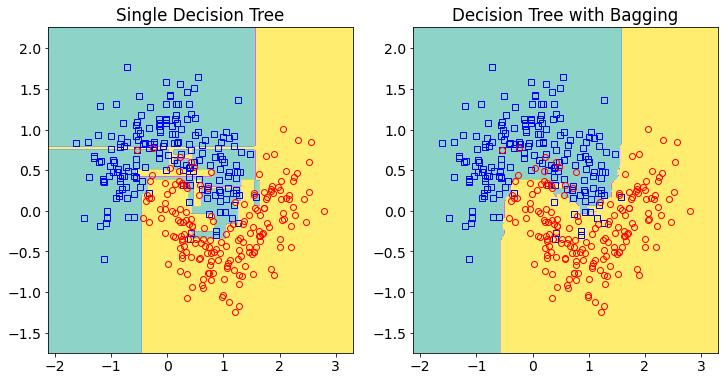

In [75]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
axs[0].plot(X_train[y_train==0][:,0], X_train[y_train==0][:,1], 'bs', fillstyle='none')
axs[0].plot(X_train[y_train==1][:,0], X_train[y_train==1][:,1], 'ro', fillstyle='none')
x1_min, x1_max = X_train[:,0].min()-0.5, X_train[:,0].max()+0.5
x2_min, x2_max = X_train[:,1].min()-0.5, X_train[:,1].max()+0.5
draw_decision_regions(dt_clf, x1_min, x1_max, x2_min, x2_max, axs[0])
axs[0].set_title("Single Decision Tree")

axs[1].plot(X_train[y_train==0][:,0], X_train[y_train==0][:,1], 'bs', fillstyle='none')
axs[1].plot(X_train[y_train==1][:,0], X_train[y_train==1][:,1], 'ro', fillstyle='none')
draw_decision_regions(bag_clf, x1_min, x1_max, x2_min, x2_max, axs[1])
axs[1].set_title("Decision Tree with Bagging")

And we can clearly see here that the bagging version has learnt the boundary much more accurately than the single DT. It is less prone to overfitting, with a more regular boundary shape = smaller variance.

## Out-of-bag evaluation

When bagging, only a fraction of the training instances are sampled for each predictor. The ones not sampled are **out-of-bag (oob) instances**. (But not the same set for _all_ predictors!)

Can evaluate bagging performance by testing on oob instances (like a sort of CV). If there are enough estimators, each instance will have several predictions from being an oob instance. CAn them compute oob accuracy.

Requires `oob_score=True`.

In [67]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500, # number of base estimators in the ensemble
    max_samples=100, # number of samples to draw from X to train each base estimator
    bootstrap=True,  # True for bagging, False for pasting
    n_jobs=-1,
    verbose=1,
    oob_score=True # get out-of-bag score
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    2.9s finished


0.9226666666666666

In [68]:
accuracy_score(bag_clf.predict(X_test), y_test)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


0.912

So the oob score is similar to the test score.

In [76]:
# get probabilities for each class for each instance
print(bag_clf.oob_decision_function_.shape)
print(bag_clf.oob_decision_function_[:10])

(375, 2)
[[0.35516373 0.64483627]
 [0.38992042 0.61007958]
 [1.         0.        ]
 [0.01822917 0.98177083]
 [0.03047091 0.96952909]
 [0.1043257  0.8956743 ]
 [0.38235294 0.61764706]
 [0.07235142 0.92764858]
 [0.95687332 0.04312668]
 [0.81769437 0.18230563]]


# Random Patches & Random Subspaces

Can also train predictors using random subset of **input features** as well as instances. Good for high-dimensional inputs, e.g. images.

**Random Patches**: sampling both instances & features

**Random Subspaces**: only sampling features; use all training instances for each predictor.

Adds in more diversity: adds a little more bias for lower variance.


Use `max_features` and `bootstrap_features=True` to sample input features (doesn't make sense on 2D input example here)

## Random Forests

**Random Forest**: ensemble of **Decision Trees**, generally trained via bagging method

Use specialist `RandomForestClassifier` class over `BaggingClassifier`, as it has optimisations for DTs

Also extra randomness when growing trees: instead of searching for best feature amongst _all_ features for each node, it uses a random subset of features - introduces natural diversity.

**Extremely-randomised trees (extra-trees)**: increase randomness by using random thresholds for each feature, rather than trying to find the best threshold. Agaon, trades bias for variance, and increases speed.

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [79]:
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_pred_rf, y_test)

0.92

### Feature importance

Can measure relative importance of features: calculate weighted average (weighted by # samples associated with node) of how much the feature reduces impurity across tree nodes that use that feature

sklearn does this automatically, scaled to sum to 1: `.feature_importances_`

# Boosting

Convert weak learners into strong learners - train predictors sequentially, each trying to correct its predecessor.

Different methods available: most popular are **Ada(ptive) Boost** and **Gradient boosting**.

## AdaBoost

General idea: pay more attention to instances a classifier **incorrectly** identified/underfitted.

First train base classifier (e.g. DT) -> make predictions on training set. Increase weight of misclassified instances -> Train another DT using updated weights -> repeat.

Have set of classifiers -> all can make predictions, combine them weighting by the accuracy of each.

Is a **sequential learning technique** - can't be parallelised - doesn't scale well like bagging/pasting.

(NB SVMs not good with AdaBoost - too slow & unstable)

Has learning rate - too high, and it overemphasises wrong instances.

The AdaBoost algorithm maths:

Calculate a weighted error rate $r_j$ for predictor $j$:

\begin{equation}
r_j = \frac{\sum^m_{i=1, \hat{y}^{(i)}_j \neq y^{(i)}} w^{(i)}}{\sum_{i=1}^m w^{(i)}}
\end{equation}

where each instance has weight $w^{(i)}$. In the first iteration, $w^{(i)} = 1/m$, where $m$ is the number of training instances. $\hat{y}^{(i)}_j$ is the prediction for the $i$th instance by the $j$th predictor. i.e. the numerator is only interested in misclassified instances.

The predictor is then assigned a weight $\alpha_j$:

\begin{equation}
\alpha_j = \eta \log \frac{1-r_j}{r_j}
\end{equation}

where $\eta$ is the learning rate hyperparameter. So the more accurate a predictor is, the smaller $r_j$ will be, and the larger $\alpha_j$ will be. If it is most often wrong, then $\alpha_j$ will be <0.

The instance weights are then updated, boosting the weights of the misclassified instances:

\begin{equation}
w^{(i)} \to 
\begin{cases}
w^{(i)} \text{ if } \hat{y}^{(i)}_j = y^{(i)} \\
w^{(i)} \exp (\alpha_j) \text{ if } \hat{y}^{(i)}_j \neq y^{(i)} 
\end{cases}
\end{equation}

and are finally normalised so that they sum to unity.

A new predictor is then trained using the updated weights, and the process repeated.

The process stops when the desired number of predictors has been trained, or a perfect predictor found.

To make a prediction, compute predictions of all the predictors, and weights them using $\alpha_j$. The final prediction is the one with the weighted majority vote from $N$ predictors:

\begin{equation}
\hat{y}(\vec{x}) = \text{argmax}_k \sum^N_{j=1, \hat{y}_j = k} \alpha_j
\end{equation}


In [7]:
from sklearn.ensemble import AdaBoostClassifier

In [81]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R', 
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [82]:
accuracy_score(ada_clf.predict(X_test), y_test)

0.896

SAMME: multiclass version of AdaBoost

Use SAMME.R to estimate class probabilities, performs better.

**Stopping overfitting**: either reduce number of estimators, or regularise the base estimator more

## Gradient Boosting

Instead of tweaking instance weights at each iteration, fit new predictor to the **residual errors** made by previous predictor.

On a DT, called **Gradient Tree Boosting** or **Gradient Boosted Regression Trees**.

Attempt to make one manually:

In [8]:
from sklearn.tree import DecisionTreeRegressor

In [129]:
# dummy noisy quadratic dataset
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [130]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [131]:
# Now train another regressor on residual errors from 1st predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [132]:
# and another regressor...
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [133]:
X_new = np.array([[0.8]])

In [134]:
# make a prediction by summing up prediction from all trees
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [135]:
y_pred

array([0.71706499])

Can use the sklearn `GradientBoostingRegressor` class instead: note that our `learning_rate` scales the contributions of each tree - using a low value may lead to underfitting, or needing more trees, however can generalise better.

**Shrinkage**: reducing the learning rate to avoid overfitting, generalise better

In [9]:
from sklearn.ensemble import GradientBoostingRegressor

In [137]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

Let's see how our DIY boosted regressor improves:

In [138]:
def make_regressor_line(reg, x_min, x_max):
    x = np.linspace(x_min, x_max, 250)
    return x, reg.predict(x.reshape(-1, 1))

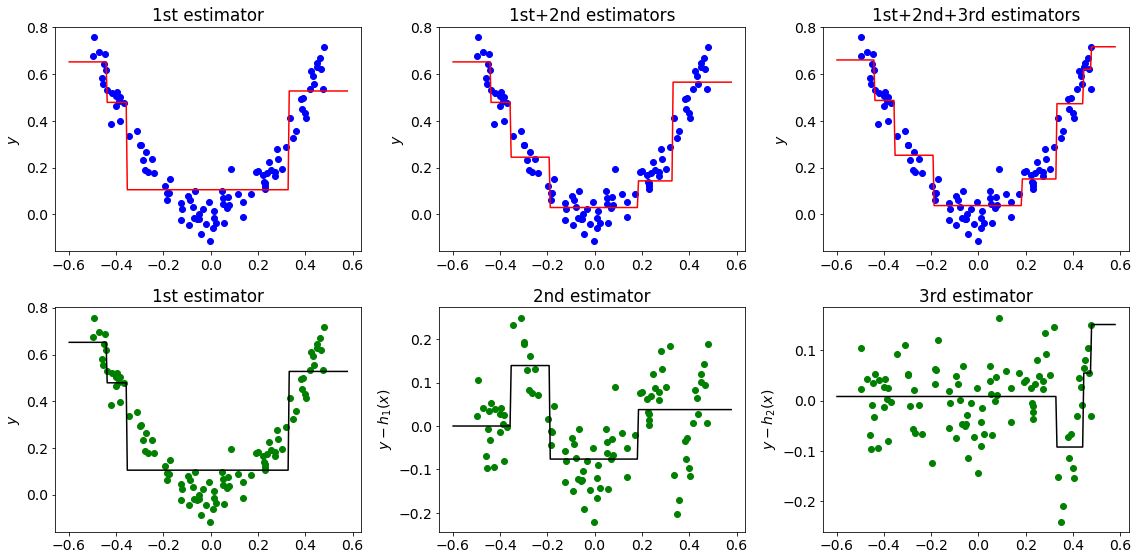

In [147]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
axs[0][0].plot(X, y, 'bo')
x_min = X.min()-0.1
x_max = X.max()+0.1
x1, y1_reg = make_regressor_line(tree_reg1, x_min, x_max)
axs[0][0].plot(x1, y1_reg, 'r-')
axs[0][0].set_title('1st estimator')
axs[0][0].set_ylabel(r'$y$')

axs[0][1].plot(X, y, 'bo')
_, y2_reg = make_regressor_line(tree_reg2, x_min, x_max)
axs[0][1].plot(x1, y1_reg+y2_reg, 'r-')
axs[0][1].set_title('1st+2nd estimators')
axs[0][1].set_ylabel(r'$y$')

axs[0][2].plot(X, y, 'bo')
_, y3_reg = make_regressor_line(tree_reg3, x_min, x_max)
axs[0][2].plot(x1, y1_reg+y2_reg+y3_reg, 'r-')
axs[0][2].set_title('1st+2nd+3rd estimators');
axs[0][2].set_ylabel(r'$y$')

axs[1][0].plot(X, y, 'go')
axs[1][0].plot(x1, y1_reg, 'k-')
axs[1][0].set_title('1st estimator')
axs[1][0].set_ylabel(r'$y$')

axs[1][1].plot(X, y2, 'go')
axs[1][1].plot(x1, y2_reg, 'k-')
axs[1][1].set_title('2nd estimator')
axs[1][1].set_ylabel(r'$y - h_1(x)$')

axs[1][2].plot(X, y3, 'go')
axs[1][2].plot(x1, y3_reg, 'k-')
axs[1][2].set_title('3rd estimator');
axs[1][2].set_ylabel(r'$y - h_2(x)$')

plt.tight_layout()

We can see that each estimator is fitting to the residuals from the _previous_ estimator, thereby providing an extra correction term. (Like doing LO + NLO + NNLO + ...)

So once we sum the predictions from all estimators, we get the "best" fit.

How to know when to stop? Want to avoid overfitting & poor generalisability

Use **early stopping**: stop at a number of trees once certain criteria met (e.g. validation error increases for N consecutive iterations)

In [10]:
from sklearn.metrics import mean_squared_error

In [148]:
# Less efficient method: We can train lots of iterations, 
# and then look back and find the minmum validation error

In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [151]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) # set n_estimators much larger than is best
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=120)

In [152]:
# We can access the predictions made by each cumulative set of trees using staged_predict()
errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)+1 # add 1 since index, and we want number of estimators

In [154]:
train_errors = [mean_squared_error(y_train, y_pred) for y_pred in gbrt.staged_predict(X_train)]

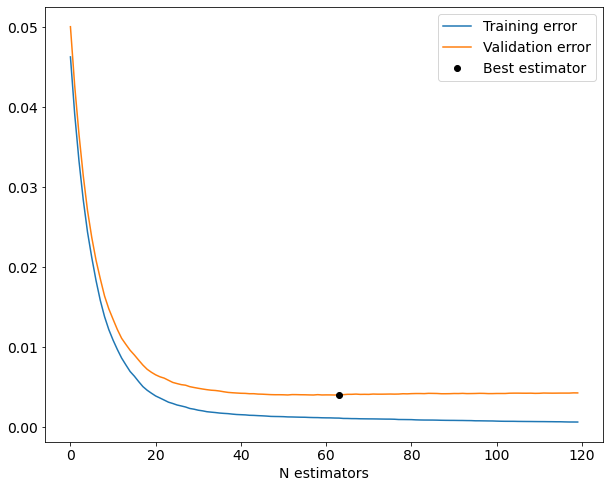

In [162]:
plt.plot(train_errors, label='Training error')
plt.plot(errors, label='Validation error');
plt.xlabel('N estimators');
plt.plot(bst_n_estimators, errors[bst_n_estimators-1], 'ko', label='Best estimator')
plt.legend();

In [153]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=63)

In [163]:
y_test_best = gbrt.predict(X_test)

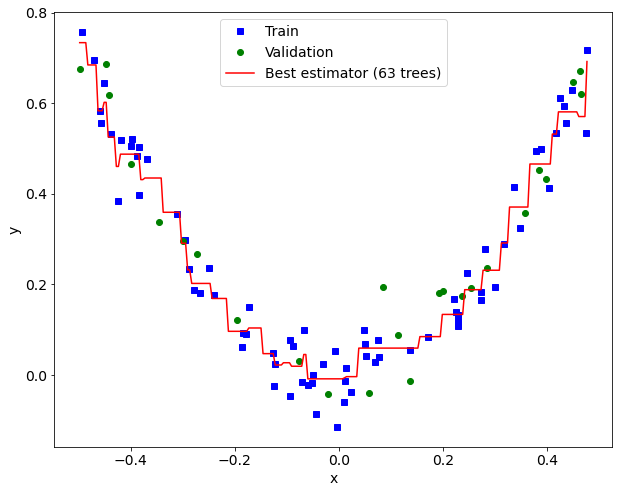

In [172]:
plt.plot(X_train, y_train, 'bs', label='Train')
plt.plot(X_test, y_test, 'go', label='Validation')
plt.plot(*make_regressor_line(gbrt_best, X.min(), X.max()), 'r-', label='Best estimator (%d trees)' % bst_n_estimators);
plt.legend();
plt.gca().set(xlabel='x', ylabel='y');

We can implement early stopping by using `warm_start=True` - this keeps existing trees when you call `fit`, caching previous results.

In [173]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = np.inf
n_error_going_up = 0

for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred)
    if test_error < min_val_error:
        min_val_error = test_error
        n_error_going_up = 0
    else:
        n_error_going_up += 1
        if n_error_going_up == 5:
            # early stopping - once error has gone up 5 times consecutively from its minimum
            break

In [175]:
gbrt.n_estimators_

57

Can also have a **stochastic gradient boosting**: only use random subset of training data (via `subsample` arg) - speeds up training, increases bias but lowers variance.

### XGBoost

Optmised version available via XGBoost library

In [11]:
import xgboost

In [198]:
xgb_reg = xgboost.XGBRegressor(max_depth=2)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_test)

In [199]:
xgb_reg.n_estimators

100

In [200]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.06786731698611631

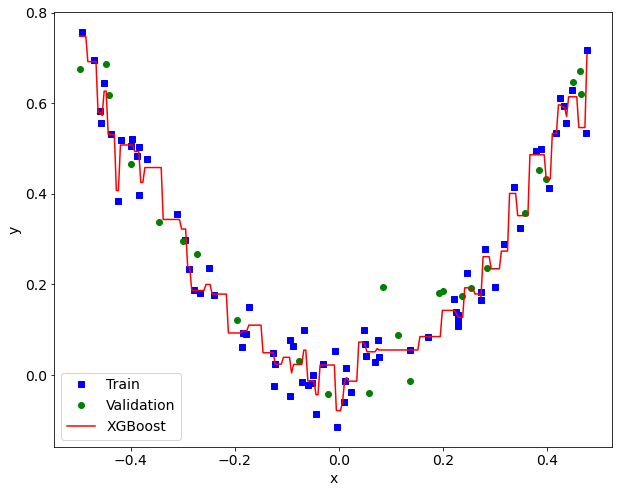

In [201]:
plt.plot(X_train, y_train, 'bs', label='Train')
plt.plot(X_test, y_test, 'go', label='Validation')
plt.plot(*make_regressor_line(xgb_reg, X.min(), X.max()), 'r-', label='XGBoost');
plt.legend();
plt.gca().set(xlabel='x', ylabel='y');

In [202]:
# Do early stopping whilst fitting:
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.21772
[1]	validation_0-rmse:0.16453
[2]	validation_0-rmse:0.12883
[3]	validation_0-rmse:0.10652
[4]	validation_0-rmse:0.08956
[5]	validation_0-rmse:0.07988
[6]	validation_0-rmse:0.07449
[7]	validation_0-rmse:0.07118
[8]	validation_0-rmse:0.07029
[9]	validation_0-rmse:0.06858
[10]	validation_0-rmse:0.06743
[11]	validation_0-rmse:0.06655
[12]	validation_0-rmse:0.06669


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [206]:
y_pred = xgb_reg.predict(X_test)
np.sqrt(mean_squared_error(y_pred, y_test))

0.06654957596722257

In [204]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.06654957596722257

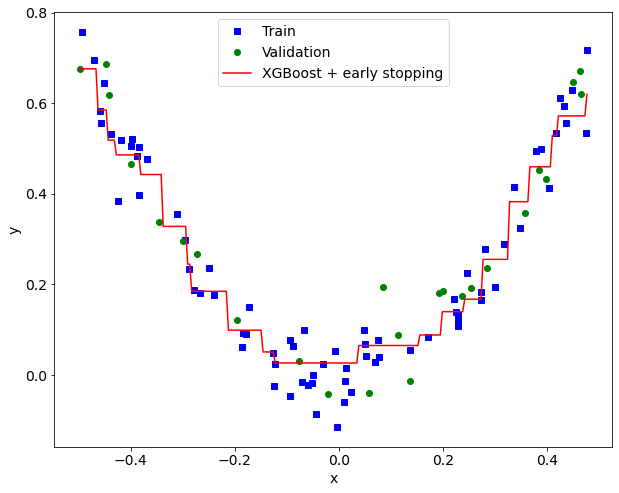

In [205]:
plt.plot(X_train, y_train, 'bs', label='Train')
plt.plot(X_test, y_test, 'go', label='Validation')
plt.plot(*make_regressor_line(xgb_reg, X.min(), X.max()), 'r-', label='XGBoost + early stopping');
plt.legend();
plt.gca().set(xlabel='x', ylabel='y');

Can see less overfitting once early stopping implemented.

# Stacking

**Stacking** = stacked generalization = take voting classifiers one step further: train a model to aggregate the predictions of all predictors in an ensemble (instead of simple e.g. hard voting).

This final predictor is called a **blender** or **meta learner**.

Requires some careful splitting of samples: split training set into 2. 

- Use 1st subset to train the N predictors

- Use those predictors to make predictions on **hold-out** set. (These were not seen during their training). Then use these N values per instance as a new set of input features to train the blender. (so its input is m x N dim)

Diagram of this blender architecture:

In [12]:
from graphviz import Digraph
from itertools import product

In [223]:
dot = Digraph(comment='Stacked ensemble')
dot.node('source', 'New instance')
dot.node('P1', 'Predictor 1')
dot.node('P2', 'Predictor 2')
dot.node('P3', 'Predictor 3')

dot.node('BF', 'Blender')
dot.node('predict', 'Prediction')

for p in ['P1', 'P2', 'P3']:
    dot.edge('source', p)
    dot.edge(p, 'BF')
dot.edge('BF', 'predict')

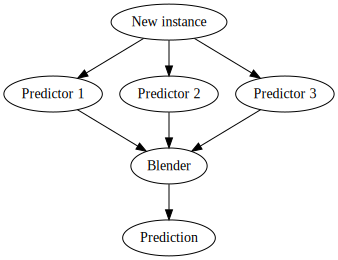

In [224]:
dot

Can actually go even further: create a layer of N' blenders using the output of the N predictors, then train one final blender to combine those N' inputs. This is a **multilayer stacking ensemble**.

This is almost a NN!

Can use `DESlib` to help do stacking, not done natively in sklearn.

In [13]:
from itertools import product

In [231]:
dot = Digraph(comment='Multilayer stacked ensemble')
dot.node('source', 'New instance')
dot.node('P1', 'Predictor 1')
dot.node('P2', 'Predictor 2')
dot.node('P3', 'Predictor 3')

dot.node('B1', 'Meta learner 1')
dot.node('B2', 'Meta learner 2')
dot.node('B3', 'Meta learner 3')

dot.node('BF', 'Final blender')
dot.node('predict', 'Prediction')

for p in ['P1', 'P2', 'P3']:
    dot.edge('source', p)
for p, b in product(['P1', 'P2', 'P3'], ['B1', 'B2', 'B3']):
    dot.edge(p, b)
for b in ['B1', 'B2', 'B3']:
    dot.edge(b, 'BF')
dot.edge('BF', 'predict')

with dot.subgraph(name='cluster_0') as c:
    c.attr(color='blue')
    c.node('P1')
    c.node('P2')
    c.node('P3')
    c.attr(label='Predictors, trained on subset of training data')

with dot.subgraph(name='cluster_1') as c:
    c.attr(color='red')
    c.node('B1')
    c.node('B2')
    c.node('B3')
    c.attr(label='Meta learners, trained on predictions from predictors on hold-out subset of training data')

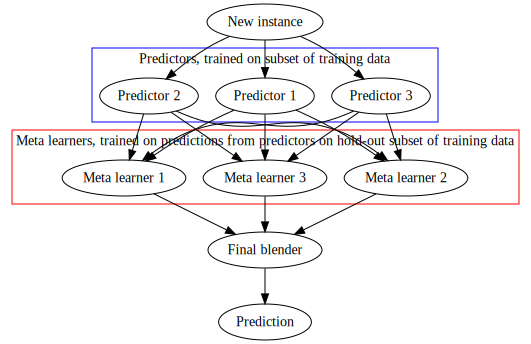

In [232]:
dot

# Exercises

## 1. Train 5 models on same training data, all 95% precision, is combining them going to improve results?

Yes - if they have different architectures / model types, then each will learn something different from the data, so worth combining.

## 2. Hard vs soft voting classifiers?

Hard voting = take the most popular choice

Soft voting = weight votes by how confident each predictor is

## 3. Speed up bagging? Pasting ensembles? Boosting ensembles? Random forests? Stacking ensembles?

Split across multiple cores/jobs:

- Bagging: yes
- Pasting: yes
- Boosting: no
- Random forests: yes
- Stacking: sort of - can parallelise within each layer

## 4. Benefit of Out-of-Bag evaluation?

Can independently evaluate performance of bagging estimator whilst training it, without needing additional validation set = more data for training

## 5. Why are Extra-Trees more random than Random Forests? How can this help? Faster or slower?

More random because they randomly select the threshold for each node splitting

Adds more diversity - lowers variance at expense of bias

Faster - trying to find optimum threshold is slow.

## 6. AdaBoost is underfitting - what to tweak?

Increase `max_depth`, increase `n_estimators`, increase `learning_rate`

## 7. Gradient boost overfitting - how to tweak learning rate?

Decrease learning rate to avoid overfitting - corrector predictors have less influence.

## 8. Load MNIST - create own ensemble

In [14]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [17]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [18]:
X_train = X[:50000]
y_train = y[:50000]
X_valid = X[50000:60000]
y_valid = y[50000:60000]
X_test = X[60000:]
y_test = y[60000:]

In [19]:
rf_clf = RandomForestClassifier(max_depth=5, n_jobs=-1, verbose=True)

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

In [20]:
xt_clf = ExtraTreesClassifier(max_depth=5, n_jobs=-1, verbose=True)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [22]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=1, gamma='scale', verbose=True, probability=True))
])

In [23]:
hard_voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xt', xt_clf),
        ('svc', svm_clf)
    ],
    voting='hard',
    n_jobs=-1,
    verbose=False
)
hard_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5, n_jobs=-1,
                                                     verbose=True)),
                             ('xt',
                              ExtraTreesClassifier(max_depth=5, n_jobs=-1,
                                                   verbose=True)),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               SVC(C=1, probability=True,
                                                   verbose=True))]))],
                 n_jobs=-1, verbose=True)

In [24]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xt', xt_clf),
        ('svc', svm_clf)
    ],
    voting='soft',
    n_jobs=-1,
    verbose=False
)
soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5, n_jobs=-1,
                                                     verbose=True)),
                             ('xt',
                              ExtraTreesClassifier(max_depth=5, n_jobs=-1,
                                                   verbose=True)),
                             ('svc',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('clf',
                                               SVC(C=1, probability=True,
                                                   verbose=True))]))],
                 n_jobs=-1, verbose=True, voting='soft')

Let's see how both fared:

In [26]:
for clf in (hard_voting_clf, soft_voting_clf):
    print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


VotingClassifier 0.88674 0.8971


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


VotingClassifier 0.98262 0.9701


The soft voting classifier has done much better than the hard voting one!

In [29]:
soft_voting_clf.estimators_

[RandomForestClassifier(max_depth=5, n_jobs=-1, verbose=True),
 ExtraTreesClassifier(max_depth=5, n_jobs=-1, verbose=True),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', SVC(C=1, probability=True, verbose=True))])]

In [31]:
fitted_svm = soft_voting_clf.estimators_[-1].named_steps['clf']

In [32]:
fitted_svm.n_support_

array([ 773,  563, 1712, 1703, 1352, 1603, 1193, 1607, 1645, 1727],
      dtype=int32)

So our SVC has anywhere from ~500 to 1700 support vectors per class. Since the prediction algorithm for an SVM takes $O(n_{SV} \times n)$, where $n_{SV}$ is the number of support vectors, and $n=784$, that is gonna take a while...

Check the accuracy of each part of our soft voting classifier, to see which classifiers were the strongest:

In [33]:
for clf in soft_voting_clf.estimators_:
    print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier training: 0.86012 validation: 0.874 test: 0.8659


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


ExtraTreesClassifier training: 0.83202 validation: 0.8518 test: 0.8419
Pipeline training: 0.98554 validation: 0.9687 test: 0.9643


What we can see is that the overall 97.0% accuracy on the validation set is basically entirely driven by the SVC (which has accuracy 96.9%). So adding the other two adds nothing much?

Let's try making a voting classifier, just using the random forest & extra trees:

In [34]:
soft_voting_no_svc_clf = VotingClassifier(
    estimators=[
        ('rf', rf_clf),
        ('xt', xt_clf),
    ],
    voting='soft',
    n_jobs=-1,
    verbose=False
)
soft_voting_no_svc_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=5, n_jobs=-1,
                                                     verbose=True)),
                             ('xt',
                              ExtraTreesClassifier(max_depth=5, n_jobs=-1,
                                                   verbose=True))],
                 n_jobs=-1, verbose=True, voting='soft')

In [35]:
clf = soft_voting_no_svc_clf
print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_job

VotingClassifier training: 0.85524 validation: 0.8704 test: 0.8624


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


So just using the random forest and extra trees, we have a much worse accuracy, backing up the claim that the result is basically entirely due to the SVC.

Let's see if we can improve the Random Forest performance by optimising hyperparameters: each fit of GridSearchCV will take ~ hour!

In [36]:
from sklearn.model_selection import GridSearchCV

In [38]:
params = {
    'n_estimators': np.arange(40, 240, 40),
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 5, 10],
}
grid_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), params)
grid_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': array([ 40,  80, 120, 160, 200])})

In [39]:
print('Best params:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)
print("All results:")
cvres = grid_clf.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

Best params: {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}
Best score: 0.8869199999999999
All results:
0.61526 {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 40}
0.63652 {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 80}
0.63374 {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 120}
0.6362599999999999 {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 160}
0.63246 {'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}
0.6195999999999999 {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 40}
0.62478 {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 80}
0.6403 {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 120}
0.63696 {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 160}
0.62764 {'max_depth': 2, 'min_samples_leaf': 5, 'n_estimators': 200}
0.6195999999999999 {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 40}
0.63408 {'max_depth': 2, 'min_samples_leaf': 10, 'n_estimators': 80}
0.63774 {'max_depth': 2, 

We hit the limit of our phase space, so let's expand it more:

In [ ]:
params = {
    'n_estimators': np.arange(200, 500, 100),
    'max_depth': np.arange(6, 15, 4),
    'min_samples_leaf': [10, 20, 30],
}
grid_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=3)
grid_clf.fit(X_train, y_train)

In [42]:
print('Best params:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)
print("All results:")
cvres = grid_clf.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

Best params: {'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 400}
Best score: 0.9492000115595912
All results:
0.8852001227106143 {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 200}
0.8858000495096302 {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 300}
0.8871001051117823 {'max_depth': 6, 'min_samples_leaf': 10, 'n_estimators': 400}
0.8845800763091903 {'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 200}
0.8854401083105183 {'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 300}
0.8864600867109024 {'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 400}
0.8841400767088463 {'max_depth': 6, 'min_samples_leaf': 30, 'n_estimators': 200}
0.8866601067114623 {'max_depth': 6, 'min_samples_leaf': 30, 'n_estimators': 300}
0.8871600967116624 {'max_depth': 6, 'min_samples_leaf': 30, 'n_estimators': 400}
0.939360012751743 {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 200}
0.939920001551967 {'max_depth': 10, 'min_samples_leaf': 10, 'n_estimat

In [43]:
clf = grid_clf.best_estimator_
print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

RandomForestClassifier training: 0.97518 validation: 0.9611 test: 0.9579


In [44]:
params = {
    'n_estimators': np.arange(400, 600, 50),
    'max_depth': np.arange(14, 23, 4),
    'min_samples_leaf': [10, 15],
}
grid_clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=3)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': array([14, 18, 22]),
                         'min_samples_leaf': [10, 15],
                         'n_estimators': array([400, 450, 500, 550])})

In [45]:
print('Best params:', grid_clf.best_params_)
print('Best score:', grid_clf.best_score_)
print("All results:")
cvres = grid_clf.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(mean_score, params)

Best params: {'max_depth': 22, 'min_samples_leaf': 10, 'n_estimators': 450}
Best score: 0.9507399915604232
All results:
0.9489799871589272 {'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 400}
0.9493400003594791 {'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 450}
0.9491200035593672 {'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 500}
0.9498599959598071 {'max_depth': 14, 'min_samples_leaf': 10, 'n_estimators': 550}
0.9446199903555031 {'max_depth': 14, 'min_samples_leaf': 15, 'n_estimators': 400}
0.9446599859554471 {'max_depth': 14, 'min_samples_leaf': 15, 'n_estimators': 450}
0.9448200031559191 {'max_depth': 14, 'min_samples_leaf': 15, 'n_estimators': 500}
0.9447600091559911 {'max_depth': 14, 'min_samples_leaf': 15, 'n_estimators': 550}
0.9497999767593752 {'max_depth': 18, 'min_samples_leaf': 10, 'n_estimators': 400}
0.9499599879597271 {'max_depth': 18, 'min_samples_leaf': 10, 'n_estimators': 450}
0.9499999787595752 {'max_depth': 18, 'min_samples_leaf': 10,

In [47]:
clf = grid_clf.best_estimator_
print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

RandomForestClassifier training: 0.9781 validation: 0.9628 test: 0.9575


It seems to just keep add more depth, with very little improvement. Let's cut it off at 14, for ~95% accuracy. We'll copy the same settings for ExtraTreesClassifier to save time.

Let's now train a voting classifier with our "best" classifiers.

In [50]:
best_soft_voting_clf = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(max_depth=14, min_samples_leaf=10, n_estimators=400, n_jobs=-1)),
        ('xt', ExtraTreesClassifier(max_depth=14, min_samples_leaf=10, n_estimators=400, n_jobs=-1)),
        ('svc', SVC(kernel='rbf', C=1, gamma='scale', probability=True))
    ],
    voting='soft',
    n_jobs=-1,
    verbose=False
)
best_soft_voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=14,
                                                     min_samples_leaf=10,
                                                     n_estimators=400,
                                                     n_jobs=-1)),
                             ('xt',
                              ExtraTreesClassifier(max_depth=14,
                                                   min_samples_leaf=10,
                                                   n_estimators=400,
                                                   n_jobs=-1)),
                             ('svc', SVC(C=1, probability=True))],
                 n_jobs=-1, voting='soft')

In [51]:
for clf in [best_soft_voting_clf, *best_soft_voting_clf.estimators_]:
    print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

VotingClassifier training: 0.98862 validation: 0.9792 test: 0.9766
RandomForestClassifier training: 0.97504 validation: 0.9621 test: 0.9568
ExtraTreesClassifier training: 0.97214 validation: 0.96 test: 0.9545
SVC training: 0.98958 validation: 0.9802 test: 0.9785


The overall ensemble voting classifier has a 2% improvement in accuracy (98%) on the individual classifiers (96%). Although using these optimised random forest & extra trees classifiers hasn't really improved the overall performance ever so slightly (was 98% before) - presumably as a soft voting classifier, the weighting for the SVC is greatest, so it dominated the votes. Whereas I would expect a significant improvement in a hard voting classifier, which values the random forest and extra tree classifiers equally.

We can check this just by changing the `voting` attribute:

In [52]:
best_soft_voting_clf.voting = 'hard'

In [53]:
for clf in [best_soft_voting_clf, *best_soft_voting_clf.estimators_]:
    print(clf.__class__.__name__, 'training:', clf.score(X_train, y_train), 'validation:', clf.score(X_valid, y_valid), 'test:', clf.score(X_test, y_test))

VotingClassifier training: 0.97742 validation: 0.9665 test: 0.9606
RandomForestClassifier training: 0.97504 validation: 0.9621 test: 0.9568
ExtraTreesClassifier training: 0.97214 validation: 0.96 test: 0.9545
SVC training: 0.98958 validation: 0.9802 test: 0.9785


So we can clearly see the improvement in hard voting classifier (from 89% to 97%)! Although interestingly the ensemble has a slightly lower accuracy than the SVC by itself!

## 9. Use output from individual classifiers to train a blender

In [61]:
y_valid_preds = [clf.predict(X_valid) for clf in best_soft_voting_clf.estimators_]

In [62]:
y_valid_preds[0].shape

(10000,)

In [63]:
X_valid_preds = np.c_[y_valid_preds].T

In [64]:
X_valid_preds.shape

(10000, 3)

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
lg_reg = LogisticRegression(n_jobs=-1)
lg_reg.fit(X_valid_preds, y_valid)

LogisticRegression(n_jobs=-1)

In [67]:
lg_reg.score(X_valid_preds, y_valid)

0.966

Let's try a random forest instead:

In [69]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_valid_preds, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [70]:
rnd_forest_blender.score(X_valid_preds, y_valid)

0.9822

So a random forest does better as a blender than Logistic Regression, and a little bit better than the simple soft voting

Let's try it on our test set finally:

In [71]:
y_test_preds = [clf.predict(X_test) for clf in best_soft_voting_clf.estimators_]
X_test_preds = np.c_[y_test_preds].T

In [72]:
rnd_forest_blender.score(X_test_preds, y_test)

0.9738

So this gives a very comparable result to the soft voting result on the test set (0.9766).